# Titanic: Machine Learning from Disaster
---

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [77]:
# Load the dataset
data = pd.read_csv("./data/train.csv")

## Exploring the data

In [78]:
display(data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [79]:
train_size = data.shape[0]
percent_positive = data[data['Survived'] == 1].shape[0] / train_size
percent_negative = data[data['Survived'] == 0].shape[0] / train_size

In [80]:
print("Number of training examples: {}".format(train_size))
print("Positive examples: {:2.0f}%".format(percent_positive*100))
print("Negative examples: {:2.0f}%".format(percent_negative*100))

Number of training examples: 891
Positive examples: 38%
Negative examples: 62%


**Note**: The data is skewed towards negative samples, so accuracy might be misleading as a metric. We'll use the F1 score instead.

---
## Dealing with NaNs

In [81]:
display(data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

* `Age`: for age, it makes sense to use the mean as a replacement for missing values.
* `Cabin`: for cabin numbers, I think the best we can do is replace missing values with the value of the previous sample. Since cabin numbers seem to be unordered, this should be equivalent to assigning a random value to the missing datapoints.
* `Embarked`: similar to cabin numbers, we're simply going to assume that the port passengers were picked up from was random. This isn't necessarily true, since richer passengers (for example) might have picked up more frequently from one port rather than another.

In [82]:
# Replace all Age NaNs with the mean age
data["Age"].fillna(np.around(data["Age"].mean(), decimals=1), inplace=True)

In [83]:
# Forward fill, then backward fill the Cabin NaNs
data["Cabin"].fillna(method="ffill", inplace=True)
data["Cabin"].fillna(method="backfill", inplace=True)

In [84]:
# Forward/back fill Embarked NaNs
data["Embarked"].fillna(method="ffill", inplace=True)
data["Embarked"].fillna(method="backfill", inplace=True)

In [85]:
# Confirm NaNs are gone
print("Age NaN count: {}".format(data["Age"].isnull().sum()))
print("Cabin NaN count: {}".format(data["Cabin"].isnull().sum()))
print("Embarked NaN count: {}".format(data["Embarked"].isnull().sum()))

Age NaN count: 0
Cabin NaN count: 0
Embarked NaN count: 0


---
## One-hot encoding

The categorical features `Pclass`, `Sex`, `Cabin`, and `Embarked` need one-hot encoding to be useful.

If we one-hot encoded `Cabin` as-is, we would have too many features as a result, since we would be including every single cabin passengers were in. Instead, we can discard the cabin number and only focus on the deck they were on, denoted by the letter. E.g. cabin C123 is cabin 123 on deck C. This should give us the relevant information about the passengers' location on the ship, without filling the dataset with a ton of unimportant features.

In [86]:
# Prepare Cabin for one-hot encoding
data["Cabin"] = data["Cabin"].apply(lambda s: s[0])

In [87]:
# Check cabin column
display(data["Cabin"].head(10))

0    C
1    C
2    C
3    C
4    C
5    C
6    E
7    E
8    E
9    E
Name: Cabin, dtype: object

In [88]:
# Perform one-hot encoding
data = pd.get_dummies(data, columns=["Pclass", "Sex", "Cabin", "Embarked"])

In [89]:
# Check one-hot encoded features
print(data.columns)

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


---
## Removing unimportant features

We are going to assume that the names of the passengers, as well as their ticket numbers, are irrelevant to their chance of survival (i.e. they're random) and remove them from the dataset.

From on the correlations below, we can see that `PasserngerId`, `Cabin_A`, `Cabin_E`, and `Embarked_Q` are very minorly correlated with the target (correlations $-0.0050$, $0.0036$, $0.0036$, and $0.0087$ respectively). So, we're going to drop those features as well.

In [90]:
display(data.corr()["Survived"])

PassengerId   -0.005007
Survived       1.000000
Age           -0.069811
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Pclass_1       0.285904
Pclass_2       0.093349
Pclass_3      -0.322308
Sex_female     0.543351
Sex_male      -0.543351
Cabin_A        0.003650
Cabin_B        0.021249
Cabin_C       -0.044664
Cabin_D        0.030707
Cabin_E        0.003580
Cabin_F        0.018113
Cabin_G       -0.031534
Cabin_T       -0.026456
Embarked_C     0.171485
Embarked_Q     0.008660
Embarked_S    -0.155660
Name: Survived, dtype: float64

In [91]:
# Drop uninteresting features
data = data.drop(columns=["Name", "Ticket", "PassengerId", "Cabin_A", "Cabin_E", "Embarked_Q"])
display(data.head())

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_S
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,1,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,0,1,0,0,0,0,1,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,1,0,0,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,1,0,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,1,0,0,0,0,0,1


## Remove highly-correlated features

Pclass, fare: the higher the ticket class, the higher the price: makes sense.

From the heatmap below, we can spot which features are highly correlated with each other. In this case, we notice that the 3 `Pclass` features (particularly classes 1 and 3) are highly correlated with the fare. This makes sense, since `Pclass` represents the ticket class the passengers bought, which gets more expensive the higher it is. Since `Fare` can be predicted using `Pclass`, we're going to remove `Fare` from the dataset, to eliminate duplicate information.

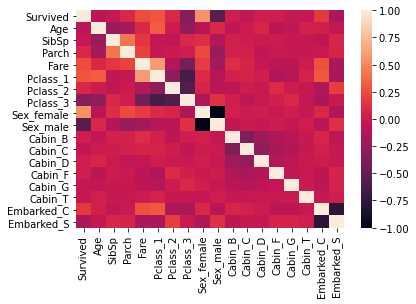

In [92]:
# Draw heatmap from the correlation table 
sns.heatmap(data.corr())
plt.show()

In [93]:
# Display a table with the correlations between the 3 classes and the fare
corr = data.corr()
df = pd.DataFrame(data=[
                        [corr["Pclass_1"]["Fare"], 
                         corr["Pclass_2"]["Fare"], 
                         corr["Pclass_3"]["Fare"]]], 
                  columns=["Pclass_1", "Pclass_2", "Pclass_3"], 
                  index=["Fare"])
display(df)

,Pclass_1,Pclass_2,Pclass_3
Fare,0.591711,-0.118557,-0.413333


In [94]:
# Drop the Fare from the dataset
data = data.drop(columns=["Fare"])

---

## Feature Scaling

The only continuous feature left in the dataset is `Age`. We are going to normalise it so that it's values are between 0 and 1.

In [95]:
# Normalise the age feature
data["Age"] = (data["Age"] - data["Age"].mean()) / (data["Age"].max() - data["Age"].min())

---

## Model selection

### Train-Test Split

In [96]:
# Split data into X and y
X = data.iloc[:, 1:]
y = data["Survived"]

In [97]:
# Do train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
print("Training set size: {}".format(X_train.shape[0]))
print("Testing set size: {}".format(X_test.shape[0]))

Training set size: 712
Testing set size: 179


### Train-Predict Pipeline

In the following cell, we'll implement a function to automatically train a model on the training data and compute the f1 score on both the training and test datasets.

In [99]:
def train_predict(model):
    """
    Computes the f1 score of a model on the training and test sets.
    
    :model: classifier to evaluate
    :return: pair of f1 score on the train and test sets
    """
    
    model = model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    test_preds  = model.predict(X_test)
    
    f1_train = f1_score(y_train, train_preds)
    f1_test  = f1_score(y_test, test_preds)
    return (f1_train, f1_test)

### Model Evaluation
In the following two cells, we'll compute the f1 score for each of the models on both the training and test sets.

In [100]:
# Compute the f1 score of every model
models = [LogisticRegression(random_state=42), SVC(random_state=42), AdaBoostClassifier(random_state=42)]
f1_scores = [train_predict(model) for model in models]

In [101]:
# Display a table with the scores
df_scores = pd.DataFrame(data=[[f1[0] for f1 in f1_scores], [f1[1] for f1 in f1_scores]], index=["Train", "Test"], columns=[type(model).__name__ for model in models])
display(df_scores)

,LogisticRegression,SVC,AdaBoostClassifier
Train,0.736220,0.754717,0.762089
Test,0.777778,0.750000,0.767123


From the table above we can see that AdaBoost has the smallest gap between the train and test f1 scores, so we'll choose that as our model.

In [110]:
chosen_model = AdaBoostClassifier(random_state=42)

Let's plot a learning curve for our model to assess whether it's overfitting or underfitting.

In [111]:
def plot_learning_curve(model):
    
    start = time.time()
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, scoring=make_scorer(f1_score), random_state=42)
    end = time.time()
    print("Learning curve time: {:0.2f}s".format(end-start))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("F1 score")
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean, train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean, test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")

    plt.show()

Learning curve time: 2.27s


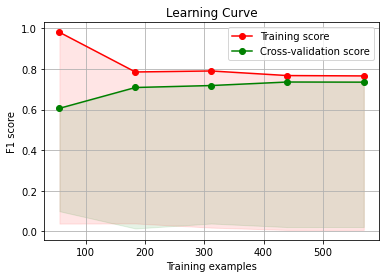

In [112]:
plot_learning_curve(chosen_model)

From the learning curve we can see that the training and validation scores converge just below 0.8 f1 score. The model might be underfitting the data. The next step is to perform hyperparameter tuning to see if we can improve the performance.

---
## Hyperparameter Tuning

In [105]:
parameters = {"n_estimators": [50, 100, 200, 500, 1000], "learning_rate": [0.001, 0.05, 0.1, 0.5, 1.0]}

In [ ]:
grid_search = GridSearchCV(chosen_model, param_grid=parameters, scoring=make_scorer(f1_score))

start = time.time()
grid_fit = grid_search.fit(X_train, y_train)
end = time.time()
print("Grid search time: {:2.2f}s".format(end-start))

In [ ]:
# Print the best model
best_clf = grid_fit.best_estimator_
print(best_clf)

---
## Final Model Evaluation

In [ ]:
# Learning curve
plot_learning_curve(best_clf)

In [ ]:
f1_train, f1_test = train_predict(best_clf)
print("F1 score (train): {:0.2f}".format(f1_train))
print("F1 score (test): {:0.2f}".format(f1_test))

The model didn't improve at all from the one with the default parameters.

---

## Final Training and Submission

In [ ]:
# Load the test set
test = pd.read_csv("./data/test.csv")

In [ ]:
# Remove missing values
test["Age"].fillna(np.around(test["Age"].mean(), decimals=1), inplace=True)
test["Cabin"].fillna(method="ffill", inplace=True)
test["Cabin"].fillna(method="backfill", inplace=True)
test["Embarked"].fillna(method="ffill", inplace=True)
test["Embarked"].fillna(method="backfill", inplace=True)

# One-hot encoding
test["Cabin"] = test["Cabin"].apply(lambda s: s[0])
test = pd.get_dummies(test, columns=["Pclass", "Sex", "Cabin", "Embarked"])

# Drop unimportant features
test = test.drop(columns=["Name", "Ticket", "PassengerId", "Cabin_A", "Cabin_E", "Embarked_Q"])
test = test.drop(columns=["Fare"])

# Feature scaling
test["Age"] = (test["Age"] - test["Age"].mean()) / (test["Age"].max() - test["Age"].min())

In [ ]:
display(test.head())

In [ ]:
# Add missing column to test set
test["Cabin_T"] = np.zeros(test.shape[0])

In [ ]:
# Display test to confirm
display(test.head())

In [ ]:
# Use the whole dataset for training
X = data.iloc[:, 1:]
y = data["Survived"]
best_clf = best_clf.fit(X, y)

In [ ]:
# Predict test labels
test_labels = pd.Series(best_clf.predict(test))

In [ ]:
# Load passenger labels
test_orig = pd.read_csv("./data/test.csv")
ids = test_orig["PassengerId"]

In [ ]:
# Create DataFrame for submission
test_submission = pd.DataFrame(data={"PassengerId": ids, "Survived": test_labels})
test_submission.set_index("PassengerId", inplace=True)
display(test_submission)

In [ ]:
# Produce submission file
test_submission.to_csv("./data/submission.csv")